For the compression algorithm benchmark, we will be focusing on four algorithms: `lzma`, `lzop`, `gzip`, and `bzip2`. We will be using the object files produced by `clang14` compiler in `debug` mode. There are 705 files which add up to 1609 MBs of total file size.

To find out which algorithm performs better under different bandwidth scenarios, we will compare their total elapsed time for compressing and sending the files. There are two possible approaches to calculate the elapsed time.

- Consecutive: First compress, then send. Elapsed time is the sum of compression time and transfer time.
- Streamed: Transfer simultaneously with compression. Elapsed time is the max of compression time and transfer time.

**We will be working with the streamed approach as this yields the best theoretically possible result.** The results obtained with this approach are analogous to the consecutive one, only more convenient.

The tables and plots in this report revolve around certain metrics, which are explained below.

- **Size:** Total size of all object files, in kilobytes (KB).
- **Size_C:** Total size of all object files after compression, in kilobytes (KB).
- **Bandwidth:** Data assumed to be transferred in 1 second, in kilobits per second (Kbps)
- **Transfer_Time:** `= Size ÷ Bandwidth` Time needed to transfer all uncompressed files, in seconds.
- **Transfer_Time_C:** `= Size_C ÷ Bandwidth` Time needed to transfer all compressed files, in seconds.
- **C_Time:** Time needed to compress all files, in seconds.
- **Elapsed:** `= Transfer_Time` Total elapsed time for transferring all files without compression.
- **Elapsed_C:** `= Transfer_Time + C_Time` Total elapsed time for first compressing, and then transferring the files.
- **Elapsed_S:** `= max(Transfer_Time, C_Time)` Total elapsed time for compressing and transferring simultaneously. You should look at this column for comparing the timings.

## Benchmark

The compression algorithms provide a flag for adjusting the strength of the compression. In our context, the `-1` flag yields the fastest but lightest compression whereas the `-9` flag yields the slowest but heaviest compression. To give a verdict on the suitability of an algorithm, one must consider all these levels of compression. In the following, we give an example table for the `lzma` algorithm with different flags and 8 Mbps bandwidth.

In [1]:
%config InlineBackend.figure_formats = ['svg']

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

COMPILER, MODE = 'clang14', 'release'
CSV_DIRECTORY = 'benchmarks/'
CSV_TEMPLATE  = '{compiler}_{mode}_{algorithm}_{level}.csv'

def read_csv(path):
    if os.path.exists(path):
        return pd.read_csv(path).sort_values('Size_Original', ascending=False)
    print(f'Error when reading {path}')

lzma   = {l: read_csv(CSV_DIRECTORY + CSV_TEMPLATE.format(compiler=COMPILER, mode=MODE, algorithm='lzma',   level=l)) for l in range(1, 10)}
lzop   = {l: read_csv(CSV_DIRECTORY + CSV_TEMPLATE.format(compiler=COMPILER, mode=MODE, algorithm='lzop',   level=l)) for l in range(1, 10)}
gzip   = {l: read_csv(CSV_DIRECTORY + CSV_TEMPLATE.format(compiler=COMPILER, mode=MODE, algorithm='gzip',   level=l)) for l in range(1, 10)}
bzip2  = {l: read_csv(CSV_DIRECTORY + CSV_TEMPLATE.format(compiler=COMPILER, mode=MODE, algorithm='bzip2',  level=l)) for l in range(1, 10)}
snappy = {l: read_csv(CSV_DIRECTORY + CSV_TEMPLATE.format(compiler=COMPILER, mode=MODE, algorithm='snappy', level=0)) for l in range(1, 10)}

In [2]:
def get_stats(df, bandwidth, name=''):

    columns = ['Method', 'Size', 'Size_C', 'Bandwidth', 'Transfer_Time', 'Transfer_Time_C', 'C_Time', 'Elapsed', 'Elapsed_C', 'Elapsed_S']

    total_compression_time     = sum(df['Time_Compress'])
    total_compressed_file_size = sum(df['Size_Compressed']) / 1000  # KB
    total_original_file_size   = sum(df['Size_Original']) / 1000  # KB

    file_transfer_time_compressed = 8 * total_compressed_file_size / bandwidth 
    file_transfer_time_original   = 8 * total_original_file_size / bandwidth

    elapsed_time_stream     = max(file_transfer_time_compressed, total_compression_time)
    elapsed_time_compressed = file_transfer_time_compressed + total_compression_time
    elapsed_time_original   = file_transfer_time_original

    return {
        'Method': str(name),
        'Size': int(total_original_file_size),
        'Size_C': int(total_compressed_file_size),
        'Bandwidth': bandwidth,
        'Transfer_Time': file_transfer_time_original,
        'Transfer_Time_C': file_transfer_time_compressed,
        'C_Time': total_compression_time,
        'Elapsed': file_transfer_time_original,
        'Elapsed_C': elapsed_time_compressed,
        'Elapsed_S': elapsed_time_stream
    }


def compare_flags(df, bandwidth, name, flags=range(1, 10), highlight=False):
    data = [get_stats(df[i], bandwidth, f'{name} -{i}') for i in flags]
    df = pd.DataFrame.from_dict(data)
    
    if not highlight:
        return df

    column = 'Elapsed_S'
    best = df[column].min()

    def highlight(row):
        if row[column] == best:
            return ["background-color: #aeccba; font-weight: 900;"] * len(df.columns)
        else:
            return ['color: default'] * len(df.columns)
    
    return df.style.apply(highlight, axis=1)
    
    
def compare_best(bandwidth, column='Elapsed_S', highlight=False):

    lzma_elap = compare_flags(lzma, bandwidth, 'lzma')
    lzma_best = lzma_elap.iloc[[lzma_elap[column].idxmin()], :]

    lzop_elap = compare_flags(lzop, bandwidth, 'lzop')
    lzop_best = lzop_elap.iloc[[lzop_elap[column].idxmin()], :]

    gzip_elap = compare_flags(gzip, bandwidth, 'gzip')
    gzip_best = gzip_elap.iloc[[gzip_elap[column].idxmin()], :]

    bzip2_elap = compare_flags(bzip2, bandwidth, 'bzip2')
    bzip2_best = bzip2_elap.iloc[[bzip2_elap[column].idxmin()], :]

    snappy_elap = compare_flags(snappy, bandwidth, 'snppy')
    snappy_best = snappy_elap.iloc[[snappy_elap[column].idxmin()], :]

    df = pd.concat([lzma_best, lzop_best, gzip_best, bzip2_best, snappy_best]).reset_index()

    if not highlight:
        return df

    best = df[column].min()

    def highlight(row):
        if row[column] == best:
            return ["background-color: #aeccba; font-weight: 900;"] * (len(lzma_elap.columns) + 1) #  
        else:
            return ['background-color: default'] * (len(lzma_elap.columns) + 1)

    return df.style.apply(highlight, axis=1)
    

def get_best_flag_value(df, column='Elapsed_S'):
    return df[column].idxmin() + 1


In [3]:
compare_flags(lzma, 8000, 'lzma', highlight=True)

,Method,Size,Size_C,Bandwidth,Transfer_Time,Transfer_Time_C,C_Time,Elapsed,Elapsed_C,Elapsed_S
0,lzma -1,1609852,240494,8000,1609.852960,240.494764,54.732224,1609.852960,295.226988,240.494764
1,lzma -2,1609852,237739,8000,1609.852960,237.739352,66.041708,1609.852960,303.781060,237.739352
2,lzma -3,1609852,236754,8000,1609.852960,236.754552,80.534079,1609.852960,317.288631,236.754552
3,lzma -4,1609852,228478,8000,1609.852960,228.478618,216.178345,1609.852960,444.656963,228.478618
4,lzma -5,1609852,223542,8000,1609.852960,223.542199,276.139700,1609.852960,499.681899,276.139700
5,lzma -6,1609852,221987,8000,1609.852960,221.987782,325.672455,1609.852960,547.660237,325.672455
6,lzma -7,1609852,221911,8000,1609.852960,221.911094,327.730282,1609.852960,549.641376,327.730282
7,lzma -8,1609852,221896,8000,1609.852960,221.896395,336.206586,1609.852960,558.102981,336.206586
8,lzma -9,1609852,221896,8000,1609.852960,221.896395,335.899540,1609.852960,557.795935,335.899540


In this table, the best choice for the compression flag would be `-4` as it has the smallest elapsed time (228 seconds). The time investment in compression is worth it since the raw transfer time is fairly high. However, at some point, the time spent for compression surpasses the time gained from shrinked file size, and that would be the balance point. 

For our benchmark, instead of at looking all the flags from one to nine for each algorithm, we will pick the best one and compare these among each other. Repeating this for different bandwidths will reveal if there is a clear winner, or if certain algorithms might be better under different scenarios.

In [4]:
compare_best(8000, highlight=True)

,index,Method,Size,Size_C,Bandwidth,Transfer_Time,Transfer_Time_C,C_Time,Elapsed,Elapsed_C,Elapsed_S
0,3,lzma -4,1609852,228478,8000,1609.852960,228.478618,216.178345,1609.852960,444.656963,228.478618
1,8,lzop -9,1609852,392322,8000,1609.852960,392.322396,323.817158,1609.852960,716.139554,392.322396
2,8,gzip -9,1609852,329878,8000,1609.852960,329.878330,218.674965,1609.852960,548.553295,329.878330
3,2,bzip2 -3,1609852,329131,8000,1609.852960,329.131264,114.907379,1609.852960,444.038643,329.131264
4,0,snppy -1,1609852,538805,8000,1609.852960,538.805466,27.275026,1609.852960,566.080492,538.805466


By looking at this table, we can see that the best times from the other algorithms are still way behind `lzma -4` given a 8000 Kbps bandwidth.

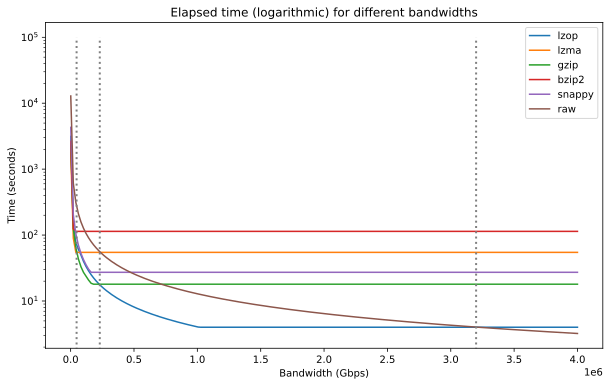

In [20]:
column = 'Elapsed_S'
column_raw = 'Elapsed'

xs = np.linspace(1000, 4000000, 200)
y1 = [compare_flags(lzop, bandwidth, 'lzop')[column].min() for bandwidth in xs]
y2 = [compare_flags(lzma, bandwidth, 'lzma')[column].min() for bandwidth in xs]
y3 = [compare_flags(gzip, bandwidth, 'gzip')[column].min() for bandwidth in xs]
y4 = [compare_flags(bzip2, bandwidth, 'bzip2')[column].min() for bandwidth in xs]
y5 = [compare_flags(snappy, bandwidth, 'snappy')[column].min() for bandwidth in xs]
y6 = [compare_flags(lzop, bandwidth, 'lzop')[column_raw].min() for bandwidth in xs]


#xs /= 1e6
plt.figure(figsize=(10, 6))
plt.xlabel('Bandwidth (Gbps)')
plt.ylabel('Time (seconds)')
plt.plot(xs, y1, label='lzop')
plt.plot(xs, y2, label='lzma')
plt.plot(xs, y3, label='gzip')
plt.plot(xs, y4, label='bzip2')
plt.plot(xs, y5, label='snappy')
plt.plot(xs, y6, label='raw')
plt.yscale('log', base=10)
plt.title('Elapsed time (logarithmic) for different bandwidths')
plt.vlines(x=47000, ymin=0, ymax=100000, colors='gray', ls=':', lw=2)
plt.vlines(x=230000, ymin=0, ymax=100000, colors='gray', ls=':', lw=2)
plt.vlines(x=3200000, ymin=0, ymax=100000, colors='gray', ls=':', lw=2)
_ = plt.legend()

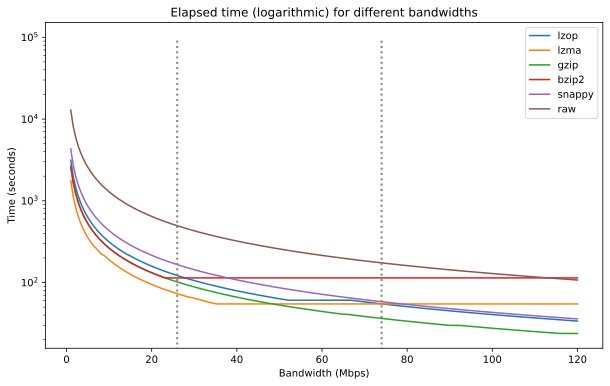

In [19]:
column = 'Elapsed_S'
column_raw = 'Elapsed'

xs = np.linspace(1000, 120000, 200)
y1 = [compare_flags(lzop, bandwidth, 'lzop')[column].min() for bandwidth in xs]
y2 = [compare_flags(lzma, bandwidth, 'lzma')[column].min() for bandwidth in xs]
y3 = [compare_flags(gzip, bandwidth, 'gzip')[column].min() for bandwidth in xs]
y4 = [compare_flags(bzip2, bandwidth, 'bzip2')[column].min() for bandwidth in xs]
y5 = [compare_flags(snappy, bandwidth, 'snappy')[column].min() for bandwidth in xs]
y6 = [compare_flags(lzop, bandwidth, 'lzop')[column_raw].min() for bandwidth in xs]

plt.figure(figsize=(10, 6))
plt.xlabel('Bandwidth (Mbps)')
plt.ylabel('Time (seconds)')
plt.plot(xs / 1e3, y1, label='lzop')
plt.plot(xs / 1e3, y2, label='lzma')
plt.plot(xs / 1e3, y3, label='gzip')
plt.plot(xs / 1e3, y4, label='bzip2')
plt.plot(xs / 1e3, y5, label='snappy')
plt.plot(xs / 1e3, y6, label='raw')
plt.yscale('log', base=10)
plt.title('Elapsed time (logarithmic) for different bandwidths')
plt.vlines(x=26, ymin=0, ymax=100000, colors='gray', ls=':', lw=2)
plt.vlines(x=74, ymin=0, ymax=100000, colors='gray', ls=':', lw=2)

_ = plt.legend()

- Between roughly 0 and 50 Mbps bandwidth, **lzma** is the most efficient.
- Between roughly 50 and 230 Mbps bandwidth, **gzip** is the most efficient. 
- Between roughly 230 and 3200 Mbps banwidth, **lzop** is the most efficient.
- From roughly 3200 Mbps on compression is not worth it.

## lzma (0-50 Mbps)
For lower bandwidths, `lzma` with its high compression ratio is the best performing algorithm.

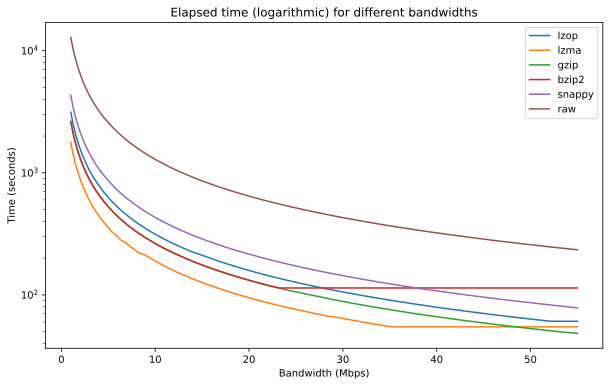

In [18]:
column = 'Elapsed_S'
column_raw = 'Elapsed'

xs = np.linspace(1000, 55000, 200)
y1 = [compare_flags(lzop, bandwidth, 'lzop')[column].min() for bandwidth in xs]
y2 = [compare_flags(lzma, bandwidth, 'lzma')[column].min() for bandwidth in xs]
y3 = [compare_flags(gzip, bandwidth, 'gzip')[column].min() for bandwidth in xs]
y4 = [compare_flags(bzip2, bandwidth, 'bzip2')[column].min() for bandwidth in xs]
y5 = [compare_flags(snappy, bandwidth, 'snappy')[column].min() for bandwidth in xs]
y6 = [compare_flags(lzop, bandwidth, 'lzop')[column_raw].min() for bandwidth in xs]

plt.figure(figsize=(10, 6))
plt.xlabel('Bandwidth (Mbps)')
plt.ylabel('Time (seconds)')
plt.plot(xs / 1e3, y1, label='lzop')
plt.plot(xs / 1e3, y2, label='lzma')
plt.plot(xs / 1e3, y3, label='gzip')
plt.plot(xs / 1e3, y4, label='bzip2')
plt.plot(xs / 1e3, y5, label='snappy')
plt.plot(xs / 1e3, y6, label='raw')
plt.yscale('log', base=10)
plt.title('Elapsed time (logarithmic) for different bandwidths')
_ = plt.legend()

The stats for different compression algorithms (only the best flag is given) for this bandwidth range can be seen below.

In [8]:
display(compare_best(1000, highlight=True))
display(compare_best(10000, highlight=True))
display(compare_best(40000, highlight=True))

,index,Method,Size,Size_C,Bandwidth,Transfer_Time,Transfer_Time_C,C_Time,Elapsed,Elapsed_C,Elapsed_S
0,7,lzma -8,1609852,221896,1000,12878.823680,1775.171160,336.206586,12878.823680,2111.377746,1775.171160
1,8,lzop -9,1609852,392322,1000,12878.823680,3138.579168,323.817158,12878.823680,3462.396326,3138.579168
2,8,gzip -9,1609852,329878,1000,12878.823680,2639.026640,218.674965,12878.823680,2857.701605,2639.026640
3,2,bzip2 -3,1609852,329131,1000,12878.823680,2633.050112,114.907379,12878.823680,2747.957491,2633.050112
4,0,snppy -1,1609852,538805,1000,12878.823680,4310.443728,27.275026,12878.823680,4337.718754,4310.443728


,index,Method,Size,Size_C,Bandwidth,Transfer_Time,Transfer_Time_C,C_Time,Elapsed,Elapsed_C,Elapsed_S
0,2,lzma -3,1609852,236754,10000,1287.882368,189.403642,80.534079,1287.882368,269.937721,189.403642
1,7,lzop -8,1609852,392557,10000,1287.882368,314.046162,217.223961,1287.882368,531.270123,314.046162
2,8,gzip -9,1609852,329878,10000,1287.882368,263.902664,218.674965,1287.882368,482.577629,263.902664
3,2,bzip2 -3,1609852,329131,10000,1287.882368,263.305011,114.907379,1287.882368,378.212391,263.305011
4,0,snppy -1,1609852,538805,10000,1287.882368,431.044373,27.275026,1287.882368,458.319399,431.044373


,index,Method,Size,Size_C,Bandwidth,Transfer_Time,Transfer_Time_C,C_Time,Elapsed,Elapsed_C,Elapsed_S
0,0,lzma -1,1609852,240494,40000,321.970592,48.098953,54.732224,321.970592,102.831177,54.732224
1,6,lzop -7,1609852,396226,40000,321.970592,79.245327,60.835625,321.970592,140.080952,79.245327
2,6,gzip -7,1609852,331221,40000,321.970592,66.244315,49.342966,321.970592,115.587282,66.244315
3,1,bzip2 -2,1609852,329628,40000,321.970592,65.925617,113.953713,321.970592,179.879330,113.953713
4,0,snppy -1,1609852,538805,40000,321.970592,107.761093,27.275026,321.970592,135.036120,107.761093


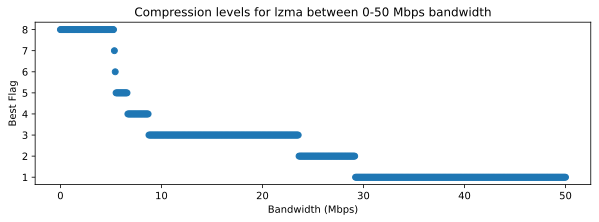

In [9]:
xs = np.linspace(1, 50000, 600)
ys = [get_best_flag_value(compare_flags(lzma, bandwidth, 'lzma')) for bandwidth in xs]

plt.figure(figsize=(10, 3))
plt.xlabel('Bandwidth (Mbps)')
plt.ylabel('Best Flag')
plt.title('Compression levels for lzma between 0-50 Mbps bandwidth')
_ = plt.scatter(xs / 1000, ys)

## gzip (50-230 Mbps)
`gzip` is a middleground between the speed of `lzop` and the density of `lzma`. For a very important range which is between 50 and 230 Mbps, `gzip` is the best performing compression algorithm in terms of elapsed time.

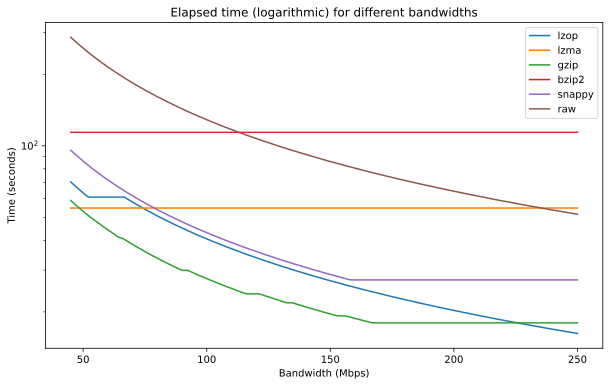

In [17]:
column = 'Elapsed_S'
column_raw = 'Elapsed'

xs = np.linspace(45000, 250000, 200)
y1 = [compare_flags(lzop, bandwidth, 'lzop')[column].min() for bandwidth in xs]
y2 = [compare_flags(lzma, bandwidth, 'lzma')[column].min() for bandwidth in xs]
y3 = [compare_flags(gzip, bandwidth, 'gzip')[column].min() for bandwidth in xs]
y4 = [compare_flags(bzip2, bandwidth, 'bzip2')[column].min() for bandwidth in xs]
y5 = [compare_flags(snappy, bandwidth, 'snappy')[column].min() for bandwidth in xs]
y6 = [compare_flags(lzop, bandwidth, 'lzop')[column_raw].min() for bandwidth in xs]

plt.figure(figsize=(10, 6))
plt.xlabel('Bandwidth (Mbps)')
plt.ylabel('Time (seconds)')
plt.plot(xs / 1e3, y1, label='lzop')
plt.plot(xs / 1e3, y2, label='lzma')
plt.plot(xs / 1e3, y3, label='gzip')
plt.plot(xs / 1e3, y4, label='bzip2')
plt.plot(xs / 1e3, y5, label='snappy')
plt.plot(xs / 1e3, y6, label='raw')
plt.yscale('log', base=10)
plt.title('Elapsed time (logarithmic) for different bandwidths')

_ = plt.legend()

The stats for different compression algorithms (only the best flag is given) for this bandwidth range can be seen below.

In [11]:
display(compare_best(50000, highlight=True))
display(compare_best(150000, highlight=True))
display(compare_best(200000, highlight=True))

,index,Method,Size,Size_C,Bandwidth,Transfer_Time,Transfer_Time_C,C_Time,Elapsed,Elapsed_C,Elapsed_S
0,0,lzma -1,1609852,240494,50000,257.576474,38.479162,54.732224,257.576474,93.211387,54.732224
1,6,lzop -7,1609852,396226,50000,257.576474,63.396262,60.835625,257.576474,124.231887,63.396262
2,6,gzip -7,1609852,331221,50000,257.576474,52.995452,49.342966,257.576474,102.338419,52.995452
3,1,bzip2 -2,1609852,329628,50000,257.576474,52.740494,113.953713,257.576474,166.694206,113.953713
4,0,snppy -1,1609852,538805,50000,257.576474,86.208875,27.275026,257.576474,113.483901,86.208875


,index,Method,Size,Size_C,Bandwidth,Transfer_Time,Transfer_Time_C,C_Time,Elapsed,Elapsed_C,Elapsed_S
0,0,lzma -1,1609852,240494,150000,85.858825,12.826387,54.732224,85.858825,67.558612,54.732224
1,1,lzop -2,1609852,507215,150000,85.858825,27.051471,4.023819,85.858825,31.075290,27.051471
2,1,gzip -2,1609852,367584,150000,85.858825,19.604513,19.252635,85.858825,38.857148,19.604513
3,1,bzip2 -2,1609852,329628,150000,85.858825,17.580165,113.953713,85.858825,131.533877,113.953713
4,0,snppy -1,1609852,538805,150000,85.858825,28.736292,27.275026,85.858825,56.011318,28.736292


,index,Method,Size,Size_C,Bandwidth,Transfer_Time,Transfer_Time_C,C_Time,Elapsed,Elapsed_C,Elapsed_S
0,0,lzma -1,1609852,240494,200000,64.394118,9.619791,54.732224,64.394118,64.352015,54.732224
1,1,lzop -2,1609852,507215,200000,64.394118,20.288604,4.023819,64.394118,24.312422,20.288604
2,0,gzip -1,1609852,375603,200000,64.394118,15.024145,17.990366,64.394118,33.014511,17.990366
3,1,bzip2 -2,1609852,329628,200000,64.394118,13.185123,113.953713,64.394118,127.138836,113.953713
4,0,snppy -1,1609852,538805,200000,64.394118,21.552219,27.275026,64.394118,48.827245,27.275026


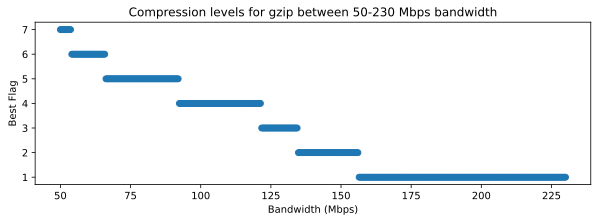

In [12]:
xs = np.linspace(50000, 230000, 400)
ys = [get_best_flag_value(compare_flags(gzip, bandwidth, 'gzip')) for bandwidth in xs]

plt.figure(figsize=(10, 3))
plt.xlabel('Bandwidth (Mbps)')
plt.ylabel('Best Flag')
plt.title('Compression levels for gzip between 50-230 Mbps bandwidth')
_ = plt.scatter(xs / 1000, ys)

## lzop (230-3200 Mbps)
For higher bandwidths, `lzop` is the best performing algorithm as it is the fastest algorithm among others with relatively lower compression ratio.

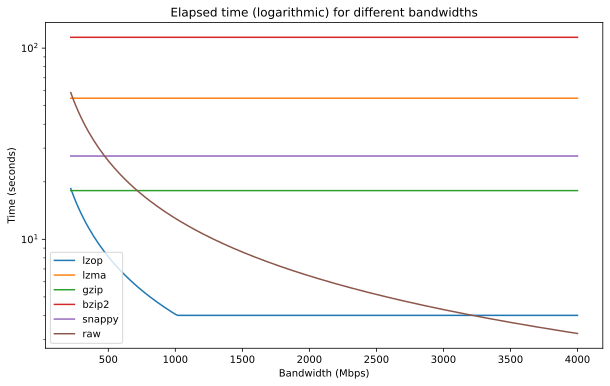

In [16]:
column = 'Elapsed_S'
column_raw = 'Elapsed'

xs = np.linspace(220000, 4000000, 200)
y1 = [compare_flags(lzop, bandwidth, 'lzop')[column].min() for bandwidth in xs]
y2 = [compare_flags(lzma, bandwidth, 'lzma')[column].min() for bandwidth in xs]
y3 = [compare_flags(gzip, bandwidth, 'gzip')[column].min() for bandwidth in xs]
y4 = [compare_flags(bzip2, bandwidth, 'bzip2')[column].min() for bandwidth in xs]
y5 = [compare_flags(snappy, bandwidth, 'snappy')[column].min() for bandwidth in xs]
y6 = [compare_flags(lzop, bandwidth, 'lzop')[column_raw].min() for bandwidth in xs]

plt.figure(figsize=(10, 6))
plt.xlabel('Bandwidth (Mbps)')
plt.ylabel('Time (seconds)')
plt.plot(xs / 1e3, y1, label='lzop')
plt.plot(xs / 1e3, y2, label='lzma')
plt.plot(xs / 1e3, y3, label='gzip')
plt.plot(xs / 1e3, y4, label='bzip2')
plt.plot(xs / 1e3, y5, label='snappy')
plt.plot(xs / 1e3, y6, label='raw')
plt.yscale('log', base=10)
plt.title('Elapsed time (logarithmic) for different bandwidths')

_ = plt.legend()

The stats for different compression algorithms (only the best flag is given) for this bandwidth range can be seen below.

In [14]:
display(compare_best(500000, highlight=True))
display(compare_best(2000000, highlight=True))
display(compare_best(3500000, highlight=True))

,index,Method,Size,Size_C,Bandwidth,Transfer_Time,Transfer_Time_C,C_Time,Elapsed,Elapsed_C,Elapsed_S
0,0,lzma -1,1609852,240494,500000,25.757647,3.847916,54.732224,25.757647,58.580141,54.732224
1,1,lzop -2,1609852,507215,500000,25.757647,8.115441,4.023819,25.757647,12.139260,8.115441
2,0,gzip -1,1609852,375603,500000,25.757647,6.009658,17.990366,25.757647,24.000024,17.990366
3,1,bzip2 -2,1609852,329628,500000,25.757647,5.274049,113.953713,25.757647,119.227762,113.953713
4,0,snppy -1,1609852,538805,500000,25.757647,8.620887,27.275026,25.757647,35.895914,27.275026


,index,Method,Size,Size_C,Bandwidth,Transfer_Time,Transfer_Time_C,C_Time,Elapsed,Elapsed_C,Elapsed_S
0,0,lzma -1,1609852,240494,2000000,6.439412,0.961979,54.732224,6.439412,55.694203,54.732224
1,2,lzop -3,1609852,507215,2000000,6.439412,2.028860,4.005106,6.439412,6.033967,4.005106
2,0,gzip -1,1609852,375603,2000000,6.439412,1.502414,17.990366,6.439412,19.492780,17.990366
3,1,bzip2 -2,1609852,329628,2000000,6.439412,1.318512,113.953713,6.439412,115.272225,113.953713
4,0,snppy -1,1609852,538805,2000000,6.439412,2.155222,27.275026,6.439412,29.430248,27.275026


,index,Method,Size,Size_C,Bandwidth,Transfer_Time,Transfer_Time_C,C_Time,Elapsed,Elapsed_C,Elapsed_S
0,0,lzma -1,1609852,240494,3500000,3.679664,0.549702,54.732224,3.679664,55.281927,54.732224
1,2,lzop -3,1609852,507215,3500000,3.679664,1.159349,4.005106,3.679664,5.164455,4.005106
2,0,gzip -1,1609852,375603,3500000,3.679664,0.858523,17.990366,3.679664,18.848888,17.990366
3,1,bzip2 -2,1609852,329628,3500000,3.679664,0.753436,113.953713,3.679664,114.707148,113.953713
4,0,snppy -1,1609852,538805,3500000,3.679664,1.231555,27.275026,3.679664,28.506582,27.275026


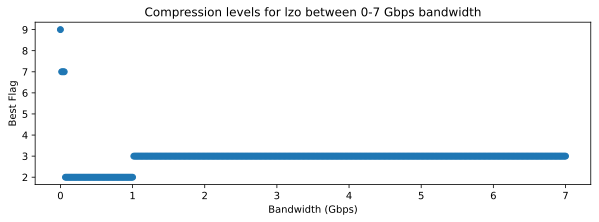

In [15]:
xs = np.linspace(1, 7000000, 400)
ys = [get_best_flag_value(compare_flags(lzop, bandwidth, 'lzop')) for bandwidth in xs]

plt.figure(figsize=(10, 3))
plt.xlabel('Bandwidth (Gbps)')
plt.ylabel('Best Flag')
plt.title('Compression levels for lzo between 0-7 Gbps bandwidth')
_ = plt.scatter(xs / 1e6, ys)

## Streamed vs. Consecutive

Until here, we assumed working with streamed compression, that is, the files are being compressed and being sent simultaneously. If we use consecutive compression instead (first compress, then send) the overall behavior of the algorithms does not change, but their optimal ranges become smaller.


 algorithm | streamed | consecutive
--|--|--
lzma | 0-50 Mbps| 0-25 Mbps
gzip | 50-230 Mbps| 25-75 Mbps
lzop | 230-3200 Mbps | 75-2200 Mbps
no compression | 3200 Mbps | 2200 Mbps